<a href="https://colab.research.google.com/github/503N-project-RC/model-training/blob/main/workalendar_vs_holidays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import holidays
!pip install workalendar
from workalendar.europe import UnitedKingdom
from google.colab import drive, files
import os

In [17]:
# load dataset from drive
drive.mount('/content/drive')
drive_base_path = '/content/drive/My Drive/503Nproj/player-count-history'
file_path = os.path.join(drive_base_path, 'player_count_history.csv')
data = pd.read_csv(file_path)
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.sort_values('date', inplace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# feature engineering w/ holidays
us_holidays = holidays.US()
data['is_holiday_holidays_lib'] = data['date'].apply(lambda x: int(x in us_holidays))

# feature engineering w/ workalendar
cal = UnitedKingdom()
data['is_holiday_workalendar'] = data['date'].apply(lambda x: int(cal.is_holiday(x)))

In [19]:
# normalization
scaler = MinMaxScaler()
player_columns = data.columns[1:-2]
data[player_columns] = scaler.fit_transform(data[player_columns])

lookback_window = 14

# prepare sequences
X, y = [], []
for i in range(len(data) - lookback_window):
    X.append(data.iloc[i:i+lookback_window, 1:-2].values)
    y.append(data.iloc[i+lookback_window, 1:-2].values)

# convert to numpy arrays
X, y = np.array(X), np.array(y)

# ensure y is of a numeric type (float32) for model compatibility
y = y.astype(np.float32)

In [20]:
# 80-20 train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [21]:
# LSTM model
def build_model():
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse')
    return model


In [22]:
print(X_train.dtype)
print(y_train.dtype)

float64
float32


In [23]:
# convert X_train & y_train to float32 to ensure compatibility with np.isnan()
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

# check for NaN values in X_train & y_train
print("NaN values in X_train:", np.isnan(X_train).sum())
print("NaN values in y_train:", np.isnan(y_train).sum())

# replace NaN values w/ 0
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

NaN values in X_train: 0
NaN values in y_train: 0


In [24]:
# model 1 training = holidays library
model_holidays = build_model()
model_holidays.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - loss: 0.0930
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0459
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0325
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0274
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0233
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0222
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0204
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0192
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0186
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0179
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0172
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0159
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0162
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0154
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0143
Epo

In [25]:
# model 2 training = workalendar library
model_workalendar = build_model()
model_workalendar.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0922
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0454
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0324
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0264
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0233
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0217
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0201
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0191
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0179
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0170
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0167
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0157
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0153
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0151
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0146
Epoc

In [26]:
# make predictions
pred_holidays = model_holidays.predict(X_test)
pred_workalendar = model_workalendar.predict(X_test)

# make inverse scale predictions
pred_holidays = scaler.inverse_transform(pred_holidays)
pred_workalendar = scaler.inverse_transform(pred_workalendar)
y_test = scaler.inverse_transform(y_test)

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


In [27]:
# performance evaluation & comparison

mse_holidays = mean_squared_error(y_test.flatten(), pred_holidays.flatten())
mae_holidays = mean_absolute_error(y_test.flatten(), pred_holidays.flatten())
r2_holidays = r2_score(y_test.flatten(), pred_holidays.flatten())

mse_workalendar = mean_squared_error(y_test.flatten(), pred_workalendar.flatten())
mae_workalendar = mean_absolute_error(y_test.flatten(), pred_workalendar.flatten())
r2_workalendar = r2_score(y_test.flatten(), pred_workalendar.flatten())

print("holidays model:")
print(f"  MSE: {mse_holidays:.5f}, MAE: {mae_holidays:.5f}, R²: {r2_holidays:.5f}")

print("\nworkalendar model:")
print(f"  MSE: {mse_workalendar:.5f}, MAE: {mae_workalendar:.5f}, R²: {r2_workalendar:.5f}")


holidays model:
  MSE: 2612788480.00000, MAE: 15302.53711, R²: 0.99313

workalendar model:
  MSE: 2836427264.00000, MAE: 15655.21387, R²: 0.99254


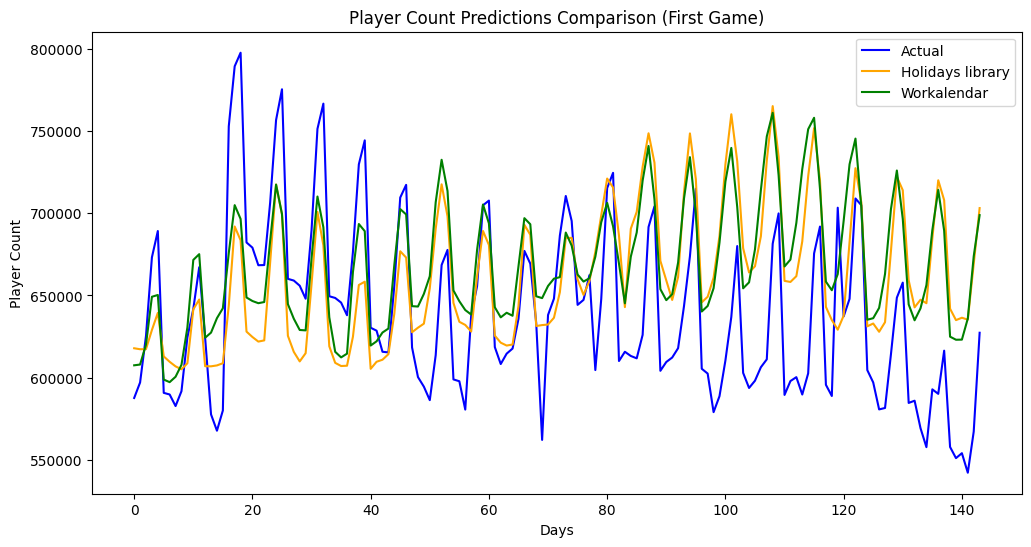

In [28]:
# comparison by plot
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='Actual', color='blue')
plt.plot(pred_holidays[:, 0], label='Holidays library', color='orange')
plt.plot(pred_workalendar[:, 0], label='Workalendar', color='green')
plt.legend()
plt.title('Player Count Predictions Comparison (First Game)')
plt.xlabel('Days')
plt.ylabel('Player Count')
plt.show()